In [30]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')

# 1. Import Data

In [31]:
# ASC Cohort
conn = sqlite3.connect('./Data/knwlg_blf.db')
dat1 = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="XXXX"', con=conn)
dat1 = dat1.loc[:,~dat1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat1 = dat1.loc[dat1.trial_type == 'test'].reset_index(drop=True)
dat1['group'] = 'Autism'

# TD cohort
conn2 = sqlite3.connect('./Data/knwlg_blf_controls.db')
dat2 = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn2)
dat2 = dat2.loc[:,~dat2.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat2 = dat2.loc[dat2.trial_type == 'test'].reset_index(drop=True)
dat2['email'] = 'N/A'
dat2['group'] = 'Neurotypical'

# Combine into one big dataframe
dat = pd.concat(objs=[dat1,dat2], ignore_index=True)
dat['response_key'] = dat.response_key.apply(literal_eval)
dat['email'] = dat.email.str.strip()

## Cleaning
### Get Email addressed for reimbursements

In [21]:
emails = dat # pd.read_sql('SELECT * FROM demographics A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="XXXX"', con=conn)

emails = emails.loc[(emails.block1_complete == True) & (emails.block2_complete == True) & (emails.block3_complete == True)]#.email.to_csv('emails.csv', sep=',')
emails = emails.loc[:,~emails.columns.duplicated()].copy()
#emails['emailed'] = '8-24-2022'
#emails['paid']= '8-24-2022'
emails = emails[['prolific_id', 'participation_date', 'email']]
emails['email'] = emails.email.str.strip()
#emails.email.sort_values().unique()
#ed.to_csv('Data/emails2.csv', sep=',')

### Note where subjects entered invalid responses

In [32]:
accepted_answers = ['f', 'j', '999']
dat['accepted_answer'] = None
for i, response in enumerate(dat.response_key):
    if sum([key.lower() in accepted_answers for key in response]) >= 1:  # == len(response):
        dat.loc[i, 'accepted_answer'] = True
    else:
        dat.loc[i, 'accepted_answer'] = False

print(f"{len(dat.loc[dat.accepted_answer == False].prolific_id.unique())} participants responded at least one trial with invalid keys. \n"
      f"{len(dat.loc[(dat.accepted_answer == False)&(dat.group == 'Neurotypical')].prolific_id.unique())} of these are from the neurotypical group. \n"
      f" {len(dat.loc[(dat.accepted_answer == False)&(dat.group == 'Autism')].prolific_id.unique())} of these are from the autism group.")

90 participants responded at least one trial with invalid keys. 
16 of these are from the neurotypical group. 
 74 of these are from the autism group.


### Convert SQL strings to python datetime object and compute timedeltas

In [33]:
dat['response_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['response_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['target_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['target_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

# 2. Accuracy

### Note trials where subjects timed-out after the 5-seconds

In [34]:
dat['timeout'] = False
# Here are timeouts without a response at all
dat.loc[dat.apply(lambda row: '999' in row['response_key'], axis=1), 'timeout'] = True
# Here is where pps pressed a key after 5 seconds, but before the experiment redirected
timeouts = dat.loc[(dat.response_key.apply(len)>1) & (dat.apply(lambda row: '999' in row['response_key'], axis=1))].index
dat.loc[timeouts, 'timeout'] = True

print(f"{len(dat.loc[dat.timeout == True].prolific_id.unique())} participants timed out during at least one trial. \n"
      f"{len(dat.loc[(dat.timeout == True)&(dat.group == 'Neurotypical')].prolific_id.unique())} of these are from the neurotypical group. \n"
      f" {len(dat.loc[(dat.timeout == True)&(dat.group == 'Autism')].prolific_id.unique())} of these are from the autism group.")

553 participants timed out during at least one trial. 
176 of these are from the neurotypical group. 
 377 of these are from the autism group.


In [35]:
# If subjects hit more than one key, use only the last one
dat['response_key'] = [resp[-1].lower() for resp in dat.response_key]

In [36]:
#  correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['correct'] = dat.apply(lambda row: row['response_key'] == row['correct_answer'], axis=1)

# timeouts are considered incorrect
dat.loc[dat.timeout == True, 'correct'] = False

## Exclude participants with mean accuracy < .6

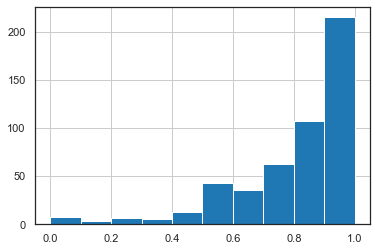

In [38]:
dat.loc[dat.group == 'Neurotypical'].groupby('prolific_id').correct.mean().hist()

In [17]:
print(f'N autism cohort before exclusion: {len(dat.loc[dat.group == "Autism"].prolific_id.unique())}')
## Exclude participants with mean accuracy < .6
xx = dat.groupby('prolific_id').correct.mean() > .6
dat = dat.loc[dat.prolific_id.isin(xx[xx == True].index.tolist())]

N autism cohort before exclusion: 441


500

In [18]:
print(f'N autism cohort after exclusion: {len(dat.loc[dat.group == "Autism"].prolific_id.unique())}')

N autism cohort after exclusion: 79


In [9]:
v_dat = dat#.loc[(dat.accepted_answer == True)]
acc = pd.DataFrame(columns=['cohort', 'agent_state', 'ascription', 'pct_correct', 'pct_incorrect'])
for gro in dat['group'].unique():
    for bel in dat.belief_type.unique():
        for ascrip in dat.ascription_type.unique():
            dd = v_dat.loc[(v_dat.group == gro)&(v_dat.belief_type==bel)&(v_dat.ascription_type==ascrip)]
            pc = len(dd.loc[dd.correct== True])/len(dd)
            ndf = pd.DataFrame({'cohort':[gro], 'agent_state':[bel], 'ascription':[ascrip], 'pct_correct':[pc], 'pct_incorrect':[1-pc]})
            acc = pd.concat([acc,ndf ], axis=0)#.reset_index(drop=True)
#sns.barplot(x='belief_type', row='group', x='ascription_type', hue='correct', kind='bar', data=)
#sns.histplot(data=v_dat, x='belief_type', hue='correct', multiple='stack', element='bars', stat='percent')

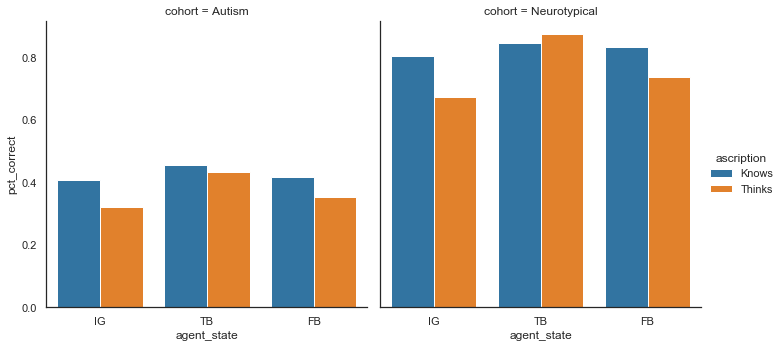

In [10]:
import matplotlib.patches as mpatches
acc['total'] = 1
acc.melt(id_vars=['cohort', 'agent_state', 'ascription'], value_vars=['pct_correct', 'total'], value_name='Percent', var_name='Accuracy')
#sns.catplot(col='belief_type', row='group', x='correct', hue='ascription_type', kind='count', data=dat)
#dat.groupby('group').prolific_id.describe()
# bar chart 1 -> top bars (group of 'smoker=No')
#f, ax = plt.subplots(1, 2)
#bar1 = sns.barplot(x="agent_state",  y="total", hue='ascription', data=acc.loc[acc.cohort == 'Neurotypical'], color='darkblue', ax=ax[0])
#bar1a = sns.barplot(x="agent_state",  y="total", hue='ascription', data=acc.loc[acc.cohort == 'Autism'],  color='darkblue', ax=ax[1])

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
#bar2 = sns.barplot(x="agent_state",  y="pct_correct", hue='ascription', data=acc.loc[acc.cohort == 'Neurotypical'], color='darkblue', ax=ax[0])
#bar2a = sns.barplot(x="agent_state",  y="pct_correct", hue='ascription', data=acc.loc[acc.cohort == 'Autism'], color='darkblue', ax=ax[1])

bar2 = sns.catplot(x="agent_state", y="pct_correct", hue='ascription', data=acc,col='cohort', kind='bar')
# add legend


In [16]:
total = v_dat.groupby(['belief_type', 'ascription_type'])['accepted_answer'].sum().reset_index()
correct = v_dat[v_dat.correct == True].groupby(['belief_type', 'ascription_type'])['accepted_answer'].sum().reset_index()

correct['pct'] = [i / j * 100 for i,j in zip(len(correct), len(total))]
total['pct'] = [i / j * 100 for i,j in zip(len(total), len(total))]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="belief_type",  y="pct", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="belief_type", y="pct", data=correct, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='incorrect')
bottom_bar = mpatches.Patch(color='lightblue', label='correct')
plt.legend(handles=[top_bar, bottom_bar])


TypeError: 'int' object is not iterable

In [19]:
len(dat.loc[dat.group == 'Autism'].prolific_id.unique())

441

In [22]:
len(dat.loc[dat.group == 'Autism'].prolific_id.unique())


79

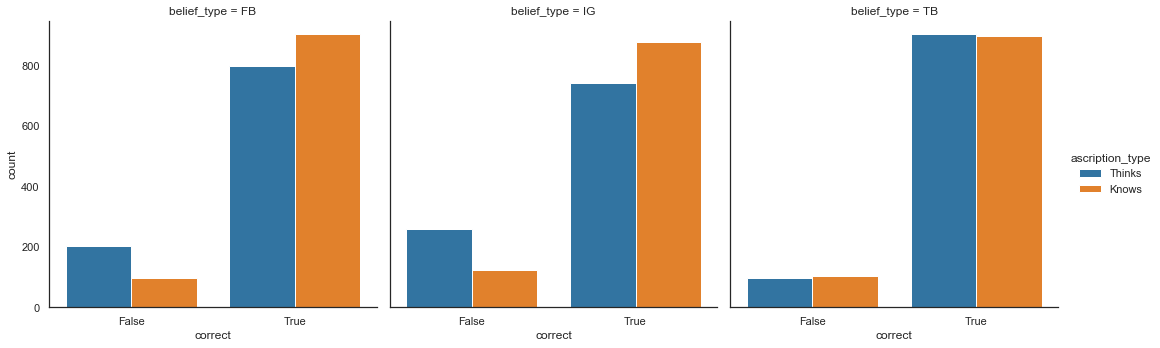

In [28]:
sns.catplot(col='belief_type', x='correct', hue='ascription_type', kind='count', data=dat)


## Check to make sure all responses came AFTER the target onset

In [29]:
sum(dat.apply(lambda row: row['response_onset'] > row['target_onset'], axis=1)) == len(dat)


True

## Exclude subjects with mean RTs less than 1500ms or more than 4000ms

In [14]:
xx = dat.groupby('prolific_id').rt_ms.mean() < 1500
dat = dat.loc[dat.prolific_id.isin(xx[xx == False].index.tolist())]
yy = dat.groupby('prolific_id').rt_ms.mean() > 4000
dat = dat.loc[dat.prolific_id.isin(yy[yy == False].index.tolist())]

for old, new in {'IG': 'Ignorance', 'TB': 'True Info', 'FB': 'False Info'}.items():
    dat.belief_type.replace(old, new, inplace=True)

# 2. Response Times

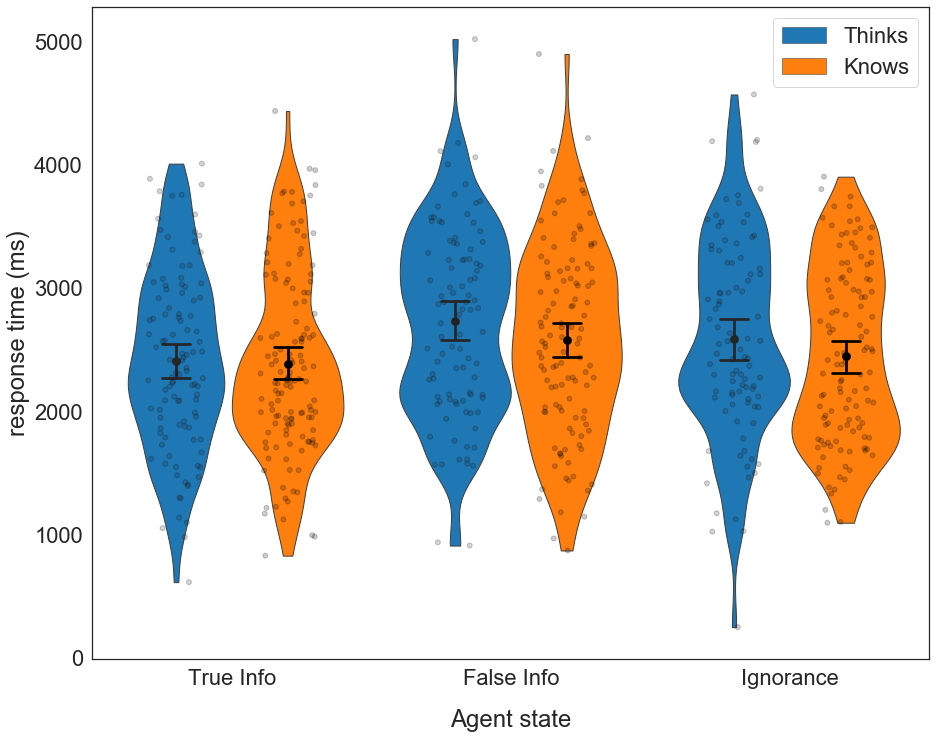

In [15]:
sns.set_context('notebook', font_scale=2)
fig, ax = plt.subplots(figsize=(15, 12))
g = sns.violinplot(x='belief_type', y='rt_ms', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', y='rt_ms', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)],
                  color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type', y='rt_ms', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
g.yaxis.set_label_text("response time (ms)")
g.xaxis.set_label_text("Agent state")
ax.xaxis.labelpad = 20

#fig.savefig('proposal_S1_control_result.png')

In [16]:
len(dat.loc[(dat.trial_type=='test') & (dat.correct==True)].prolific_id.unique())

95

# 3. Felicity Judgements

In [38]:
f_dat = pd.read_sql('SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="XXXX"', con=conn)
f_dat = f_dat.loc[:,~f_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# 1= "Sounds very weird"
# 7 = "Sounds very normal"
f_dat['Infelicity Rating'] = 8 - f_dat.felicity_rating

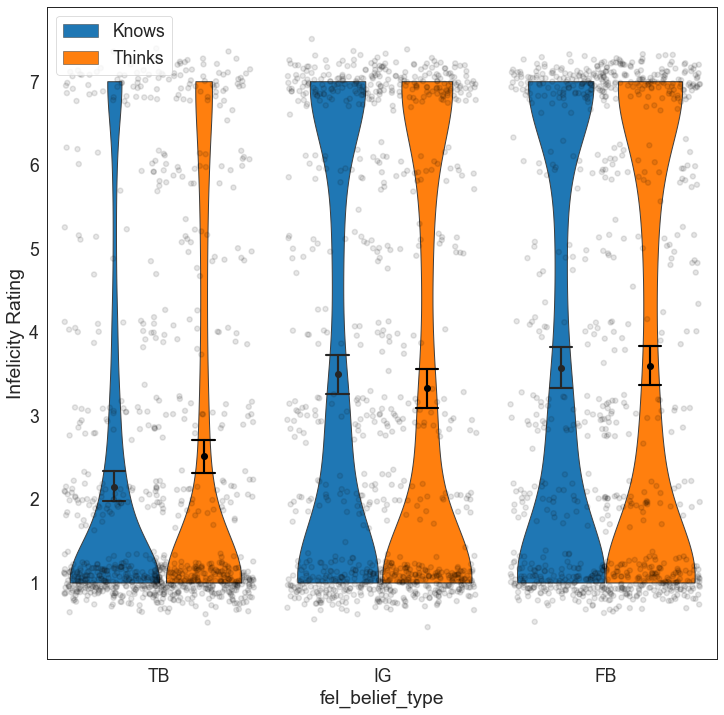

In [39]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1, order=['TB', 'IG', 'FB'])

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='fel_belief_type', y=jitter(f_dat['Infelicity Rating'], 0), hue='fel_ascription_type', data=f_dat,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['TB', 'IG', 'FB'])
g= sns.pointplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['TB', 'IG', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

# 4. AQ-10

In [19]:

a_dat = pd.read_sql('SELECT * FROM autism_scores A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="XXXX"', con=conn)
a_dat = a_dat.loc[:,~a_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

#a_dat = a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique()).values] # only use subjects in trial analysis
a_dat.describe()

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,AQ_rating_10,block1_complete,block2_complete,block3_complete
count,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.0,441.0,441.0
mean,259.548753,2.464853,3.104308,2.922902,3.151927,3.133787,3.170068,2.514739,3.333333,3.115646,2.421769,1.0,1.0,1.0
std,145.531762,1.177155,0.918499,0.901235,0.877523,0.920853,0.834273,1.136336,0.800568,0.832715,1.063390,0.0,0.0,0.0
min,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
25%,133.000000,1.000000,3.000000,2.000000,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,2.000000,1.0,1.0,1.0
50%,258.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,2.000000,1.0,1.0,1.0
75%,387.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.0,1.0,1.0
max,507.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.0,1.0,1.0


In [26]:
a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique().tolist())]

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,...,operating_sys,operating_sys_lang,GMT_timestamp,email,block1_complete,block2_complete,block3_complete,completion_code,feedback,AQ_score
1,11,4,1,1,1,1,2,2,3,1,...,None,None,2022-08-17 21:24:36.716579,juricomc@gmail.com,1,1,1,XXXX,,8
2,12,4,2,2,2,2,4,1,4,3,...,None,None,2022-08-17 21:56:32.330774,bpharris141111@gmail.com,1,1,1,XXXX,The length of the sentences did confuse me som...,7
3,13,3,2,2,3,3,2,3,4,3,...,None,None,2022-08-18 01:14:33.750285,theodoregirard44@gmail.com,1,1,1,XXXX,I tried to imagine the scenario in my head as ...,6
4,14,1,2,1,2,3,3,2,3,3,...,None,None,2022-08-18 05:35:09.702287,emmameganpitt@hotmail.co.uk,1,1,1,XXXX,for the first bit the screen was going too fas...,4
5,15,4,3,4,1,3,2,1,4,1,...,None,None,2022-08-18 13:54:46.968264,email.sarah.clark@gmail.com,1,1,1,XXXX,No difficulties. It was difficult to tell what...,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,479,4,2,2,3,3,4,1,4,2,...,None,None,2022-08-24 12:33:22.685546,austinb3njamin@gmail.com,1,1,1,XXXX,I didn't experience any technical difficulties...,5
418,481,1,3,3,2,3,3,2,3,3,...,None,None,2022-08-24 12:34:01.557317,mannila001@gmail.com,1,1,1,XXXX,This is a very good game. It requires critical...,2
420,483,1,3,3,4,4,3,1,4,3,...,None,None,2022-08-24 12:37:00.861190,joshuarobin192@gmail.com,1,1,1,XXXX,,1
437,503,4,4,3,4,4,4,4,4,3,...,None,None,2022-08-24 14:07:23.402361,shawnfrank953@gmail.com,1,1,1,XXXX,no,3


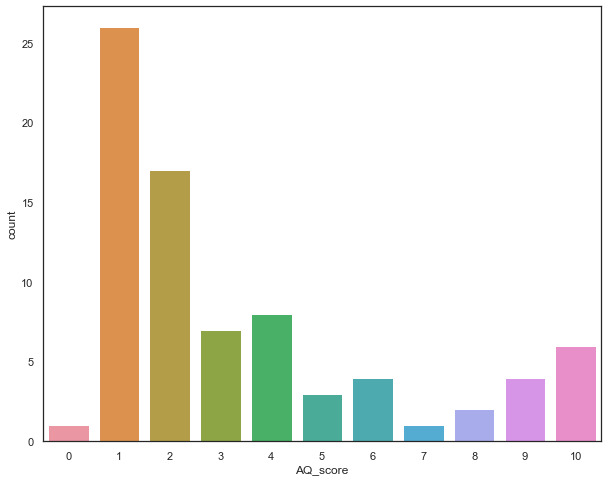

In [27]:
## Scoring
agree = ['AQ_rating_1', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_10'] # score of 3 or 4 get a point
disagree = ['AQ_rating_2','AQ_rating_3','AQ_rating_4','AQ_rating_5','AQ_rating_6','AQ_rating_9', ] # score of 1 or 2 get a point]
a = a_dat[agree] >= 3
b = a_dat[disagree] < 3
a_dat['AQ_score'] = a.sum(axis=1) + b.sum(axis=1)
a_dat = a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique().tolist())]

fg, ax = plt.subplots(figsize=(10, 8))
sns.countplot(data=a_dat, x='AQ_score', ax=ax);

In [47]:
e_dat.groupby('diag').describe()

id                                               \
                        count        mean        std    min     25%    50%   
diag                                                                         
no                       44.0  200.500000  93.125946   19.0  123.75  224.0   
prefer not to disclose    3.0  258.000000   4.000000  254.0  256.00  258.0   
yes                     211.0  143.962085  81.953695    9.0   71.00  144.0   

                                         age             ... block2_complete  \
                           75%    max  count       mean  ...             75%   
diag                                                     ...                   
no                      285.25  312.0   44.0  29.909091  ...             1.0   
prefer not to disclose  260.00  262.0    3.0  30.333333  ...             1.0   
yes                     214.50  308.0  211.0  29.227488  ...             1.0   

                            block3_complete                                     
                        max           count mean  std  min  25%  50%  75%  max  
diag                                                                            
no                      1.0            44.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
prefer not to disclose  1.0             3.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
yes                     1.0           211.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  

[3 rows x 40 columns]

In [21]:
cdat = dat.loc[dat.correct ==True]
for subject in dat.prolific_id.unique():
    # calculate mean RT for belief ascription
    a_dat.loc[a_dat.prolific_id == subject, 'avg_ThinkRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Thinks')].rt_ms.mean()
    a_dat.loc[a_dat.prolific_id == subject, 'avg_KnowRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Knows')].rt_ms.mean()

a_dat['RT_diff'] = a_dat.apply(lambda row: row['avg_ThinkRT'] - row['avg_KnowRT'], axis=1)


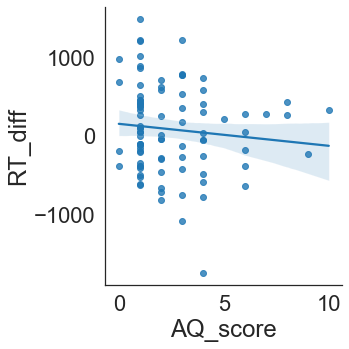

In [22]:
sns.lmplot(x='AQ_score', y='RT_diff', data=a_dat);
